In [1]:
!nvidia-smi

Fri May 17 13:17:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.44                 Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0             18W /   60W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
def DetectFaces(frame, face_cascade):
    # Convert image to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5, minSize=(30, 30))
    
    lst_face = []
    for (x,y,w,h) in faces:
        rgb_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        lst_face.append(rgb_image[y-25:y+h+25,x-25:x+w+25])
        cv2.rectangle(frame, (x-25,y-25), (x+w+25,y+h+25), (255,0,0), 2)
    return frame, lst_face



In [4]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile('haarcascade_frontalface_default.xml'))
cam = cv2.VideoCapture(0)

if not cam.isOpened():
    print("Không thể mở camera hoặc video")
else:
    while True:
        ret, frame = cam.read()
        if not ret:
            print("Không thể đọc khung hình từ camera/video")
            break
        frame_detected, _ = DetectFaces(frame=frame, face_cascade=face_cascade)
        cv2.imshow('Face Detection', frame_detected)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cam.release()
    cv2.destroyAllWindows()

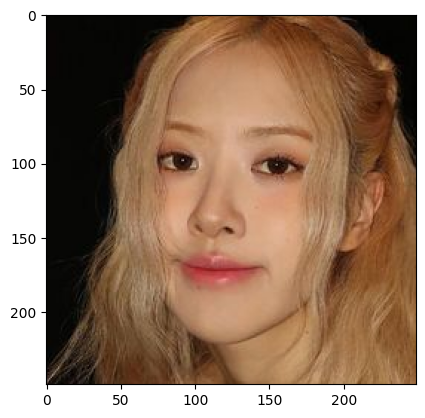

In [5]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile('haarcascade_frontalface_default.xml'))
img = cv2.imread('rosie.jpg')
_, lst_face = DetectFaces(img, face_cascade)
plt.imshow(lst_face[0])

In [6]:
image_pil = Image.fromarray(lst_face[0])

In [3]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [2]:
# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=160, margin= 20)

# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval()

In [4]:
def extract_features(PIL_Image,model,mtcnn):
    # Get cropped and prewhitened image tensor
    img_cropped = mtcnn(PIL_Image).to("cuda")
    # Calculate embedding (unsqueeze to add batch dimension)
    img_embedding = model(img_cropped.unsqueeze(0))

    img_embedding = img_embedding.detach().cpu().numpy()
    return img_embedding


In [11]:
mtcnn = MTCNN(image_size=160, margin=10)
model = InceptionResnetV1(pretrained='vggface2').eval().to("cuda")
PIL_Image = Image.open('rosie.jpg')
features = extract_features(PIL_Image,model,mtcnn)
np.savetxt('features.csv', features, delimiter=',')

In [12]:
features.shape

(1, 512)

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
from numpy import genfromtxt

In [5]:

features2 = genfromtxt('features.csv', delimiter=',')
features2 = features2.reshape((1,512))

mtcnn = MTCNN(image_size=160, margin=10)
model = InceptionResnetV1(pretrained='vggface2').eval().to("cuda")
PIL_Image = Image.open('rosie3.jpg')
features1 = extract_features(PIL_Image,model,mtcnn)

In [15]:
features1.shape

(1, 512)

In [16]:
features2.shape

(1, 512)

In [6]:
result = cosine_similarity(features1,features2)

In [9]:
result[0][0]

0.725149114813356

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torchvision import transforms
def extract_features(img, model, mtcnn):
    # Get cropped and prewhitened image tensor
    img_cropped = mtcnn(img)
    if img_cropped is None:
        return None
    img_cropped = img_cropped.to("cuda")
    # Calculate embedding (unsqueeze to add batch dimension)
    img_embedding = model(img_cropped.unsqueeze(0)).detach().cpu().numpy()
    return img_embedding

def visual_comparing(imgpath1, imgpath2):
    #====================SHOW IMAGE============================
    img1 = cv2.cvtColor(cv2.imread(imgpath1),cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(imgpath2),cv2.COLOR_BGR2RGB)
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.axis('off')
    plt.show()
    #====================EXTRACT AND COMPARE==================    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    mtcnn = MTCNN(image_size=160, margin=4, min_face_size=20, post_process=True, device = device) # Define MTCNN module
    model = InceptionResnetV1(pretrained='vggface2',device=device).eval()
    features1 = extract_features(img1,model=model,mtcnn=mtcnn)
    features2 = extract_features(img2,model=model,mtcnn=mtcnn)
    print(f"similar : {cosine_similarity(features1,features2)[0][0]}")

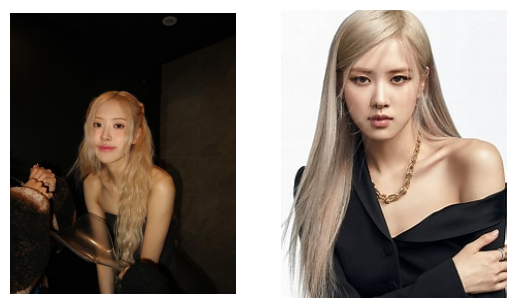

cuda cuda
similar : 0.6345093250274658


In [71]:
visual_comparing('rosie.jpg','rosie2.jpg')

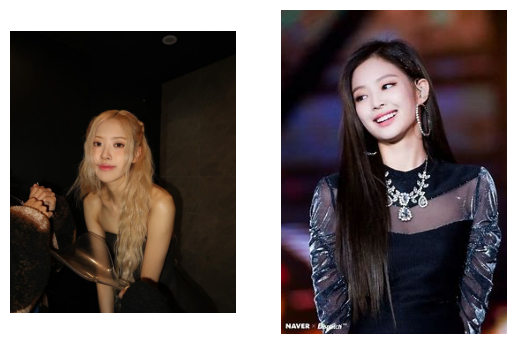

similar : 0.4012743830680847


In [61]:
visual_comparing('rosie.jpg', 'jennie.jpg')

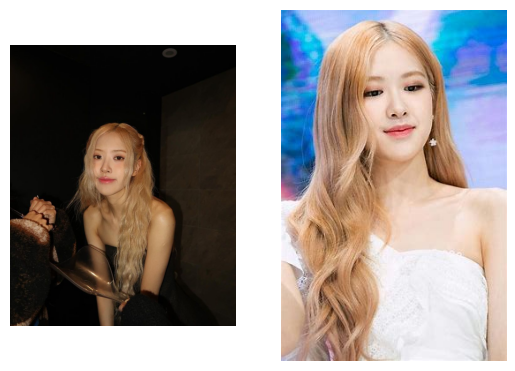

similar : 0.724097490310669


In [55]:
visual_comparing('rosie.jpg','rosie3.jpg')

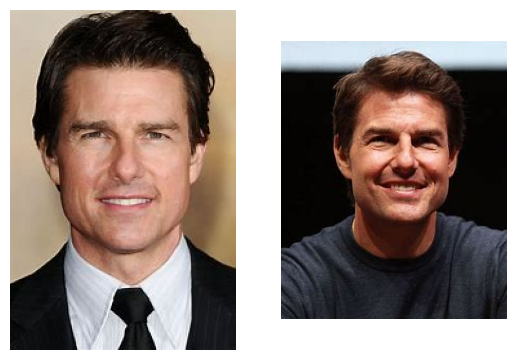

similar : 0.7752445936203003


In [56]:
visual_comparing('tom1.jpg', 'tom2.jpg')

In [3]:
!nvidia-smi


Fri May 17 17:29:25 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.44                 Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   87C    P0             37W /   60W |    1796MiB /   4096MiB |     75%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torchvision import transforms
import pandas as pd
import numpy as np
import time
import os
def extract_features(img, model, mtcnn):
    # Get cropped and prewhitened image tensor
    img_cropped = mtcnn(img)
    if img_cropped is None:
        return None
    img_cropped = img_cropped.to("cuda")
    # Calculate embedding (unsqueeze to add batch dimension)
    img_embedding = model(img_cropped.unsqueeze(0)).detach().cpu().numpy()
    return img_embedding

def extract_features_and_save(imgpath, model, mtcnn, csv_path, name):
    img = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
    features = extract_features(img, model, mtcnn)
    df = pd.DataFrame(features)
    df['Name'] = name
    if os.path.exists(csv_path):
        df.to_csv(csv_path, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_path, index=False)

def compare_with_csv(video_source, model, mtcnn, csv_path):
    cap = cv2.VideoCapture(video_source)
    df = pd.read_csv(csv_path)
    stored_features = df.drop('Name', axis=1).values
    names = df['Name'].values

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        for (x, y, w, h) in faces:
            roi = frame[y:y+h, x:x+w]
            features = extract_features(roi, model, mtcnn)
            if features is None:
                continue
            similarities = cosine_similarity(features, stored_features)[0]
            idx = np.argmax(similarities)
            max_similarity = similarities[idx]

            if max_similarity > 0.5:
                # Draw bounding box and text
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2.putText(frame, f'{names[idx]}/ Similarity:{max_similarity}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
            else:
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
                cv2.putText(frame, f'Unknown/ Similarity:{max_similarity}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)

        cv2.imshow('Video', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mtcnn = MTCNN(image_size=160, margin=0, min_face_size=20, post_process=True, device = device) # Define MTCNN module
model = InceptionResnetV1(pretrained='vggface2',device=device).eval()

In [50]:
extract_features_and_save1('phuc.jpg',model,mtcnn,'features.csv','Phuc')

In [3]:
compare_with_csv1(0,model,mtcnn,'features.csv')

In [36]:
!nvidia-smi

Fri May 17 21:00:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.44                 Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   61C    P8             14W /   60W |     910MiB /   4096MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----